# 1.对比期权理论价格和实际收盘价

基础资产：沪深300股指  
期权选择：IO2102，到期日2021.2.19  
数据区间：2021年初到2021.1.18  
股指数据来源：网易财经  
期权数据来源：中金所数据  

In [103]:
# 读取csv数据并处理
import os
import pandas as pd

call = pd.DataFrame(columns=['strike'])
put = pd.DataFrame(columns=['strike'])

listdir = os.listdir('data')
listdir.remove('hs300.csv')
listdir.sort(key=lambda x:int(x[0:8]))

for filename in listdir:
    date = filename[0:8]
    df = pd.read_csv("data/"+filename, encoding='gb18030')
    df = pd.DataFrame(df, columns=['合约代码', '今收盘'])
    df_call = pd.DataFrame(df, columns=['strike', '今收盘'])
    df_put = pd.DataFrame(df, columns=['strike', '今收盘'])
    for i in df.index.values:
        if "IO2102-C" not in df['合约代码'][i]:
            df_call = df_call.drop(index=i)
        else:
            df_call['strike'][i] = df['合约代码'][i][9:13]
        if "IO2102-P" not in df['合约代码'][i]:
            df_put = df_put.drop(index=i)
        else:
            df_put['strike'][i] = df['合约代码'][i][9:13]
    df_call = df_call.rename(columns={'今收盘':date}).reset_index(drop=True)
    df_put = df_put.rename(columns={'今收盘':date}).reset_index(drop=True)
    if list(call['strike'].values)==[] and list(put['strike'].values)==[]:
        call['strike'] = df_call['strike']
        put['strike'] = df_put['strike']
    call[date] = df_call[date]
    put[date] = df_put[date]

In [104]:
# 定义BSM期权定价公式
import numpy as np
from scipy import stats

def N(d):
    return stats.norm.cdf(d, 0, 1)

def bsm(S, K, T, r, sigma):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    C = S*N(d1) - K*np.exp(-r*T)*N(d2)
    P = C + K*np.exp(-r*T) - S # Put-call parity
    return C, P

In [105]:
# 通用参数
import numpy as np
import pandas as pd
from dateutil.parser import parse

expiration = parse('20210219').date() # 到期日
risk_free_rate = np.exp(1.75/100) - 1 # 2021年中国一年期存款利率（无风险利率）1.75%，转换成连续复利

hs = pd.read_csv("data/hs300.csv", encoding='gb18030')
hs = pd.DataFrame(hs, columns=['日期', '收盘价'])
hs = hs.set_index('日期')
sample = hs['收盘价'][0:252].values # 取2021.1.18前252天的交易日，作为计算股票波动率的数据
log_return = np.diff(np.log(sample))

sigma = np.std(log_return)*np.sqrt(252)

In [106]:
# 计算理论价格
from dateutil.parser import parse
import pandas as pd
import copy

call_theo = copy.deepcopy(call)
put_theo = copy.deepcopy(put)
date_list = call.columns[1:]

for date in date_list:
    this_day = parse(date).date()
    days_left = (expiration-this_day).days
    index = hs['收盘价'][str(this_day)]
    for i in call.index.values:
        strike = call.strike[i]
        call_price, put_price = bsm(index, strike, days_left/365, risk_free_rate, sigma)
        call_theo[date][i] = call_price
        put_theo[date][i] = put_price

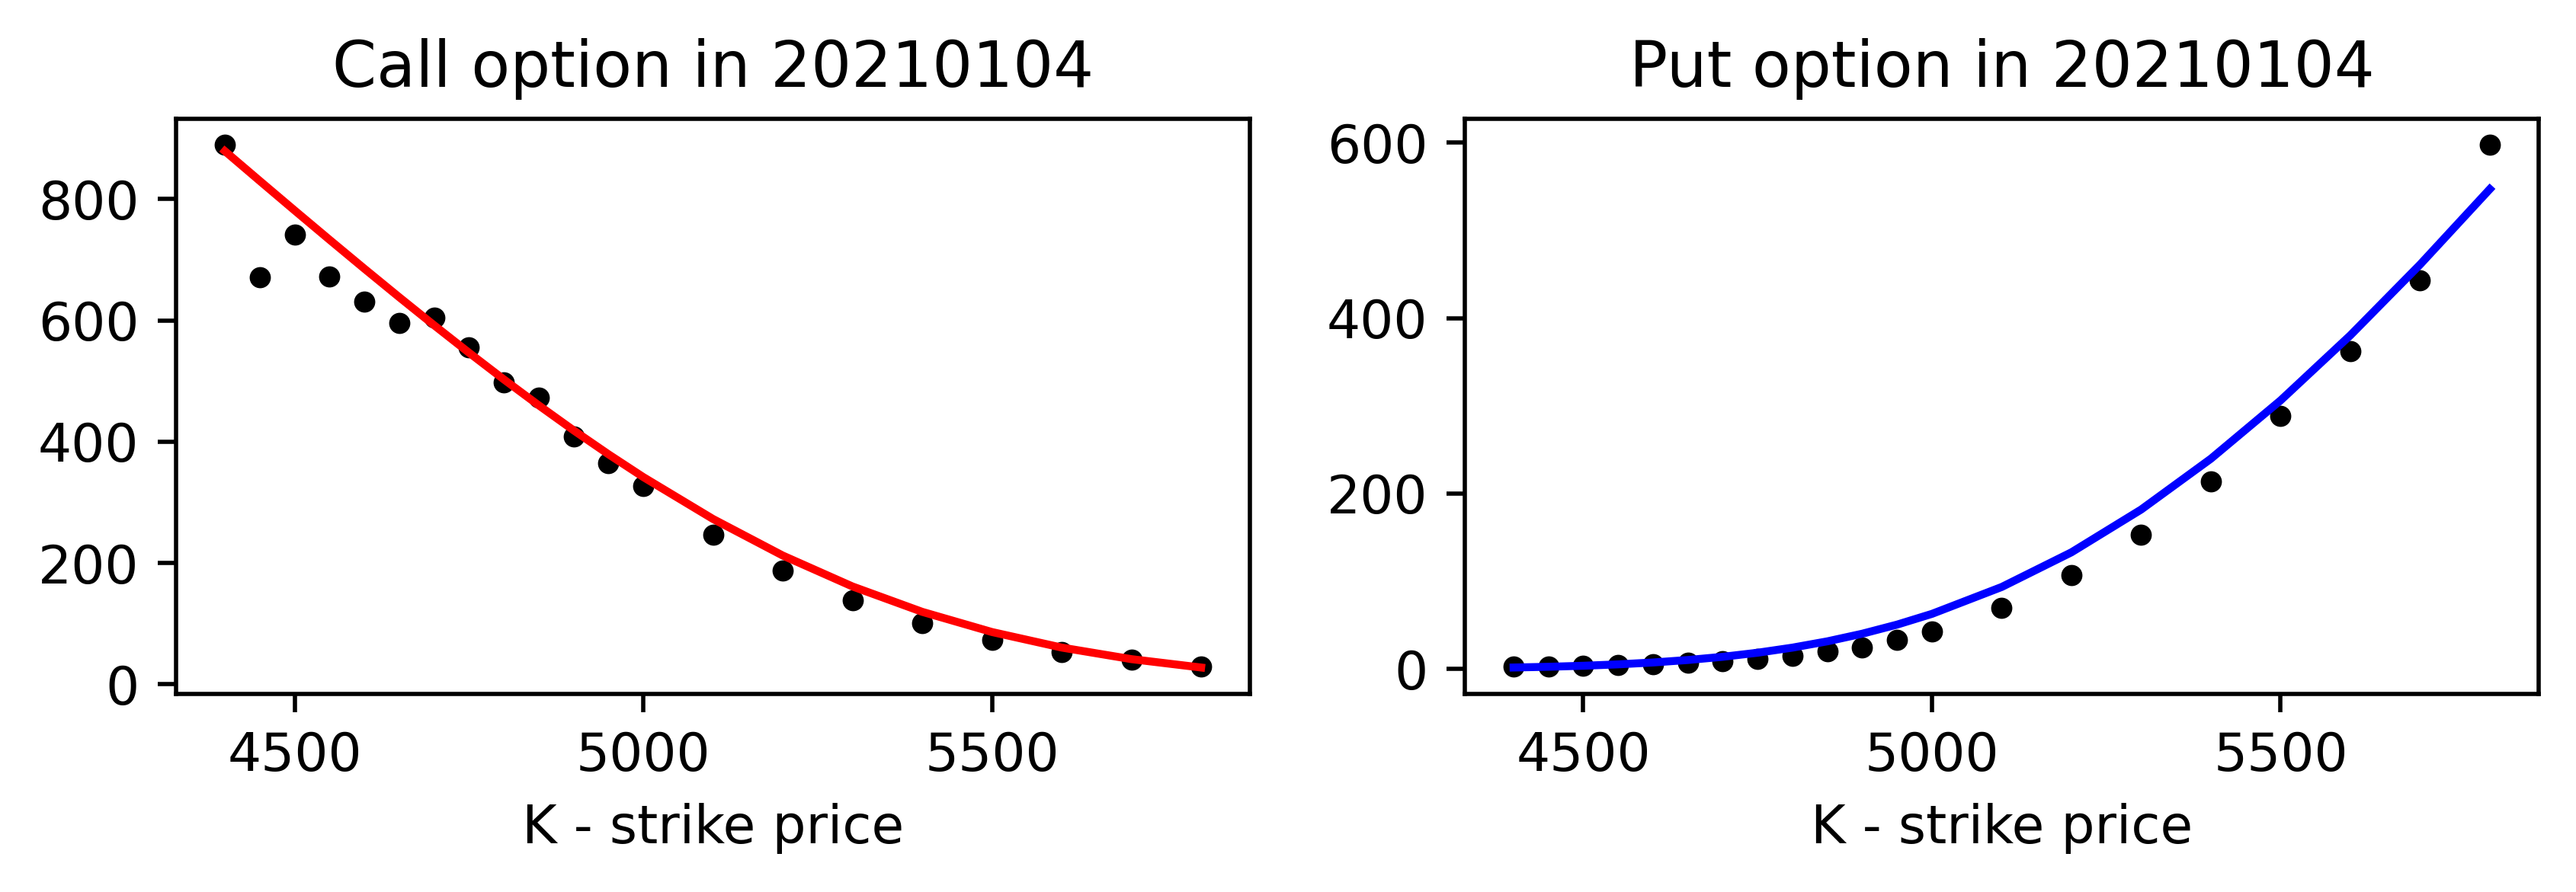

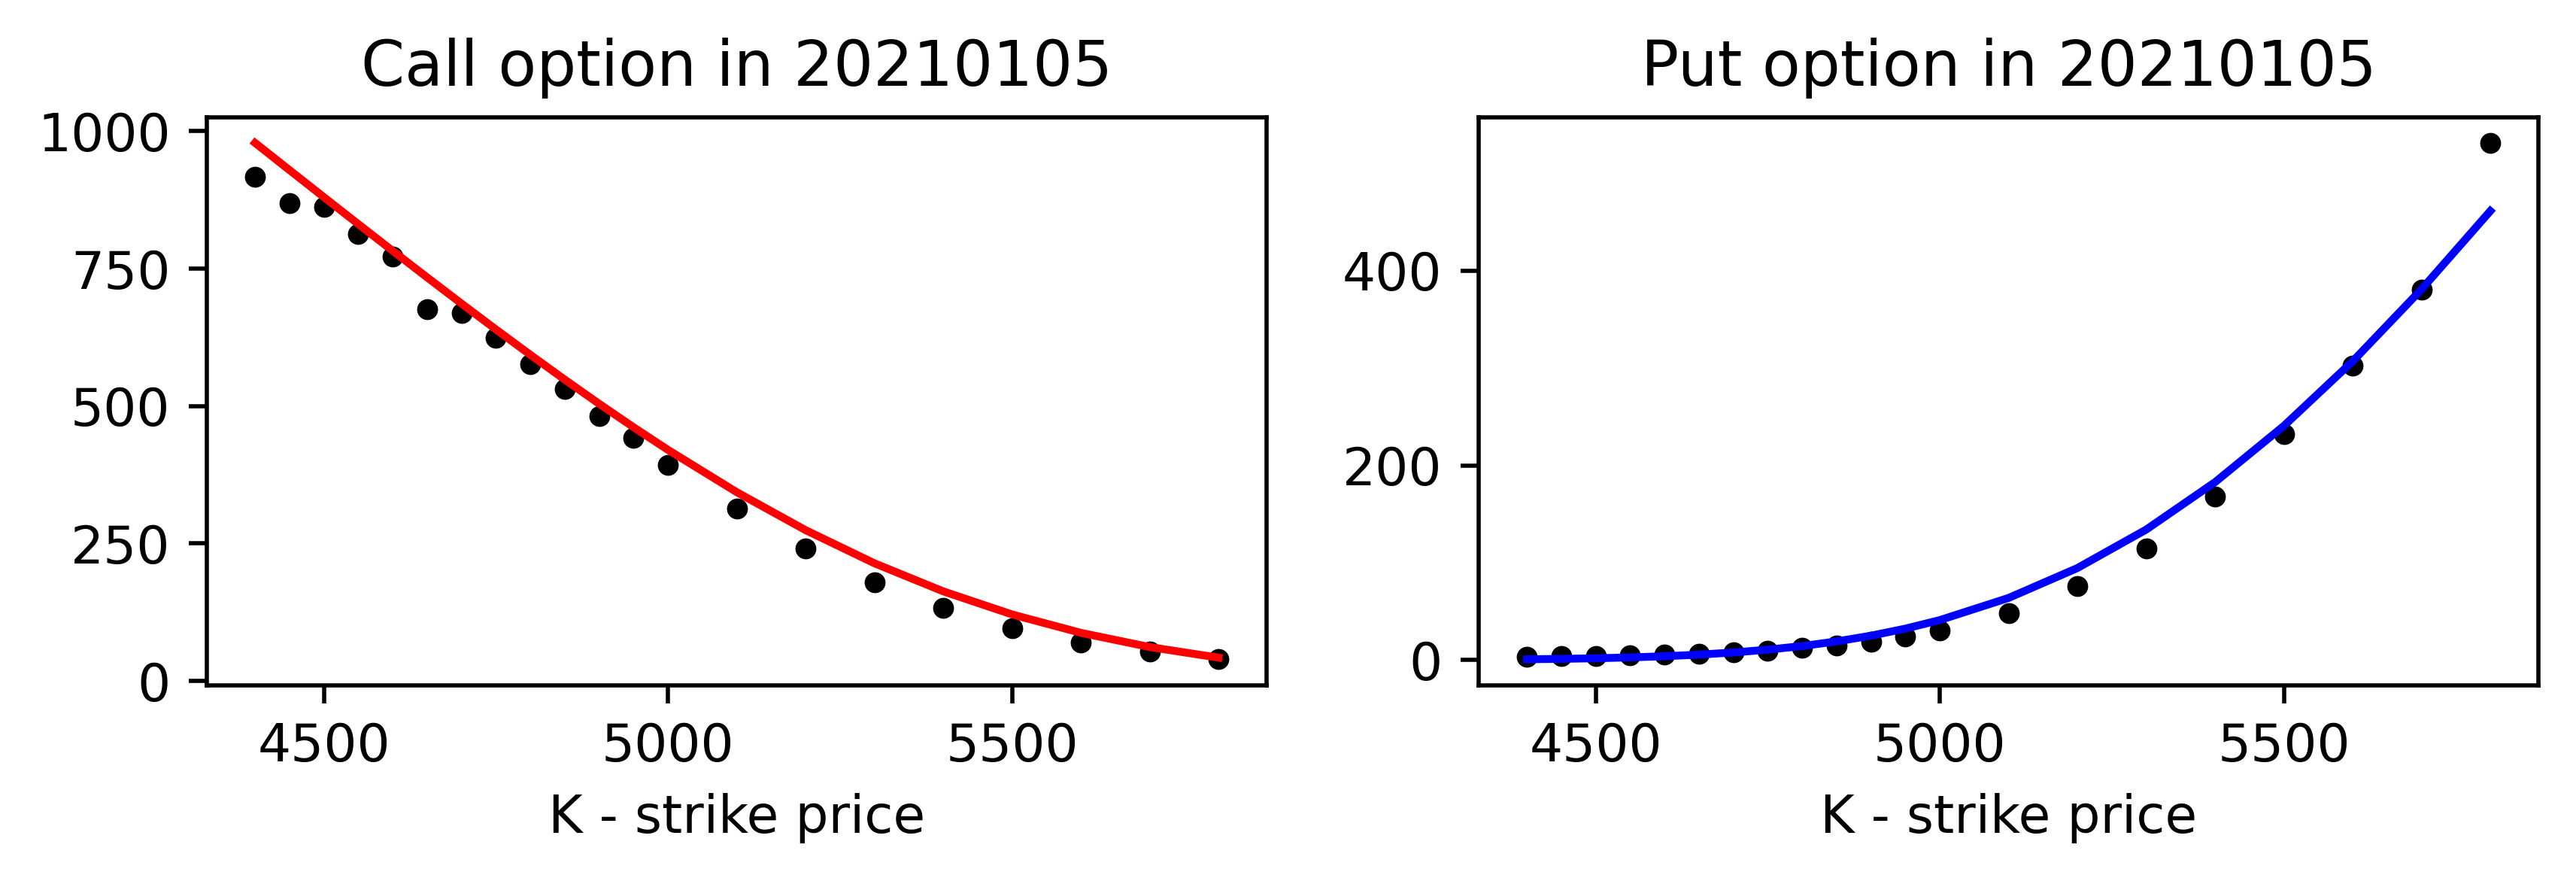

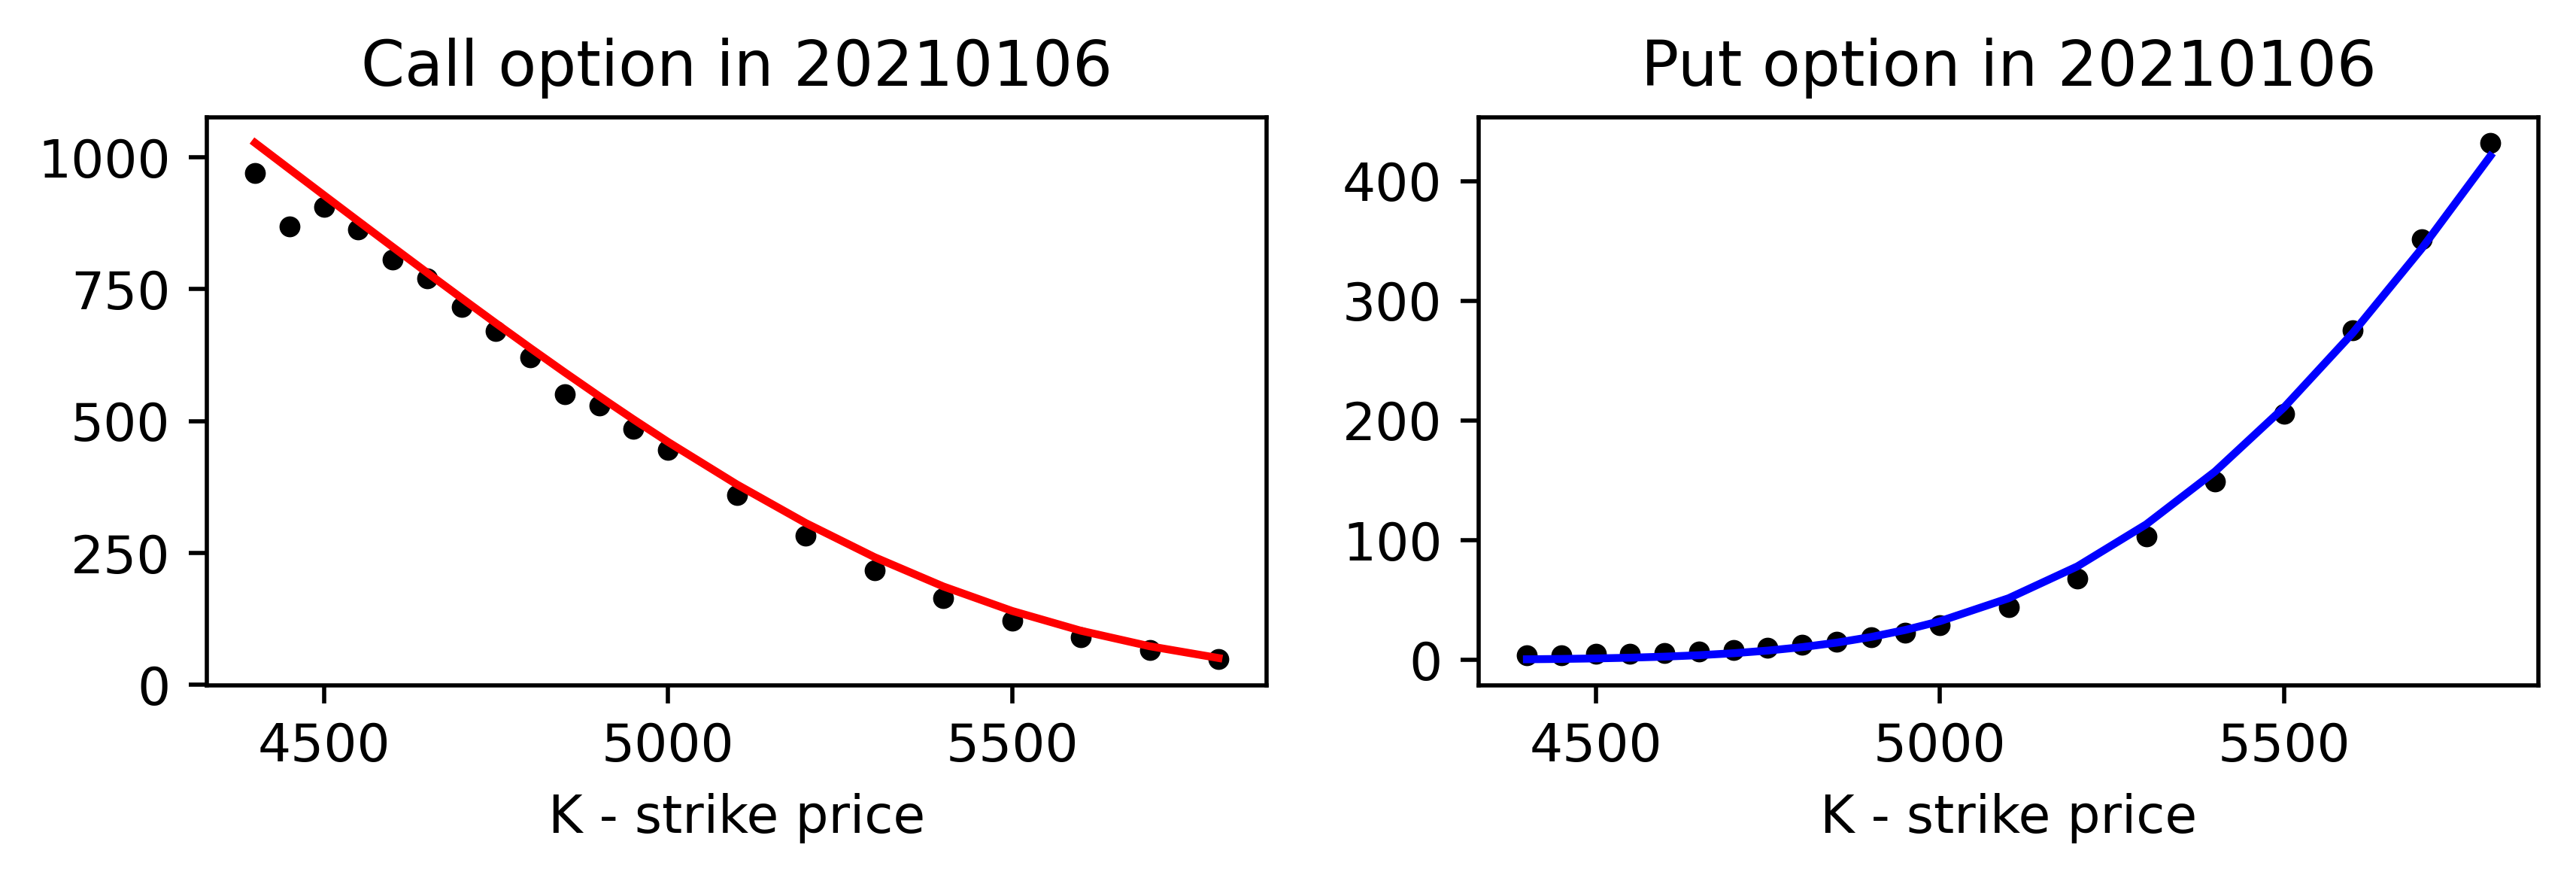

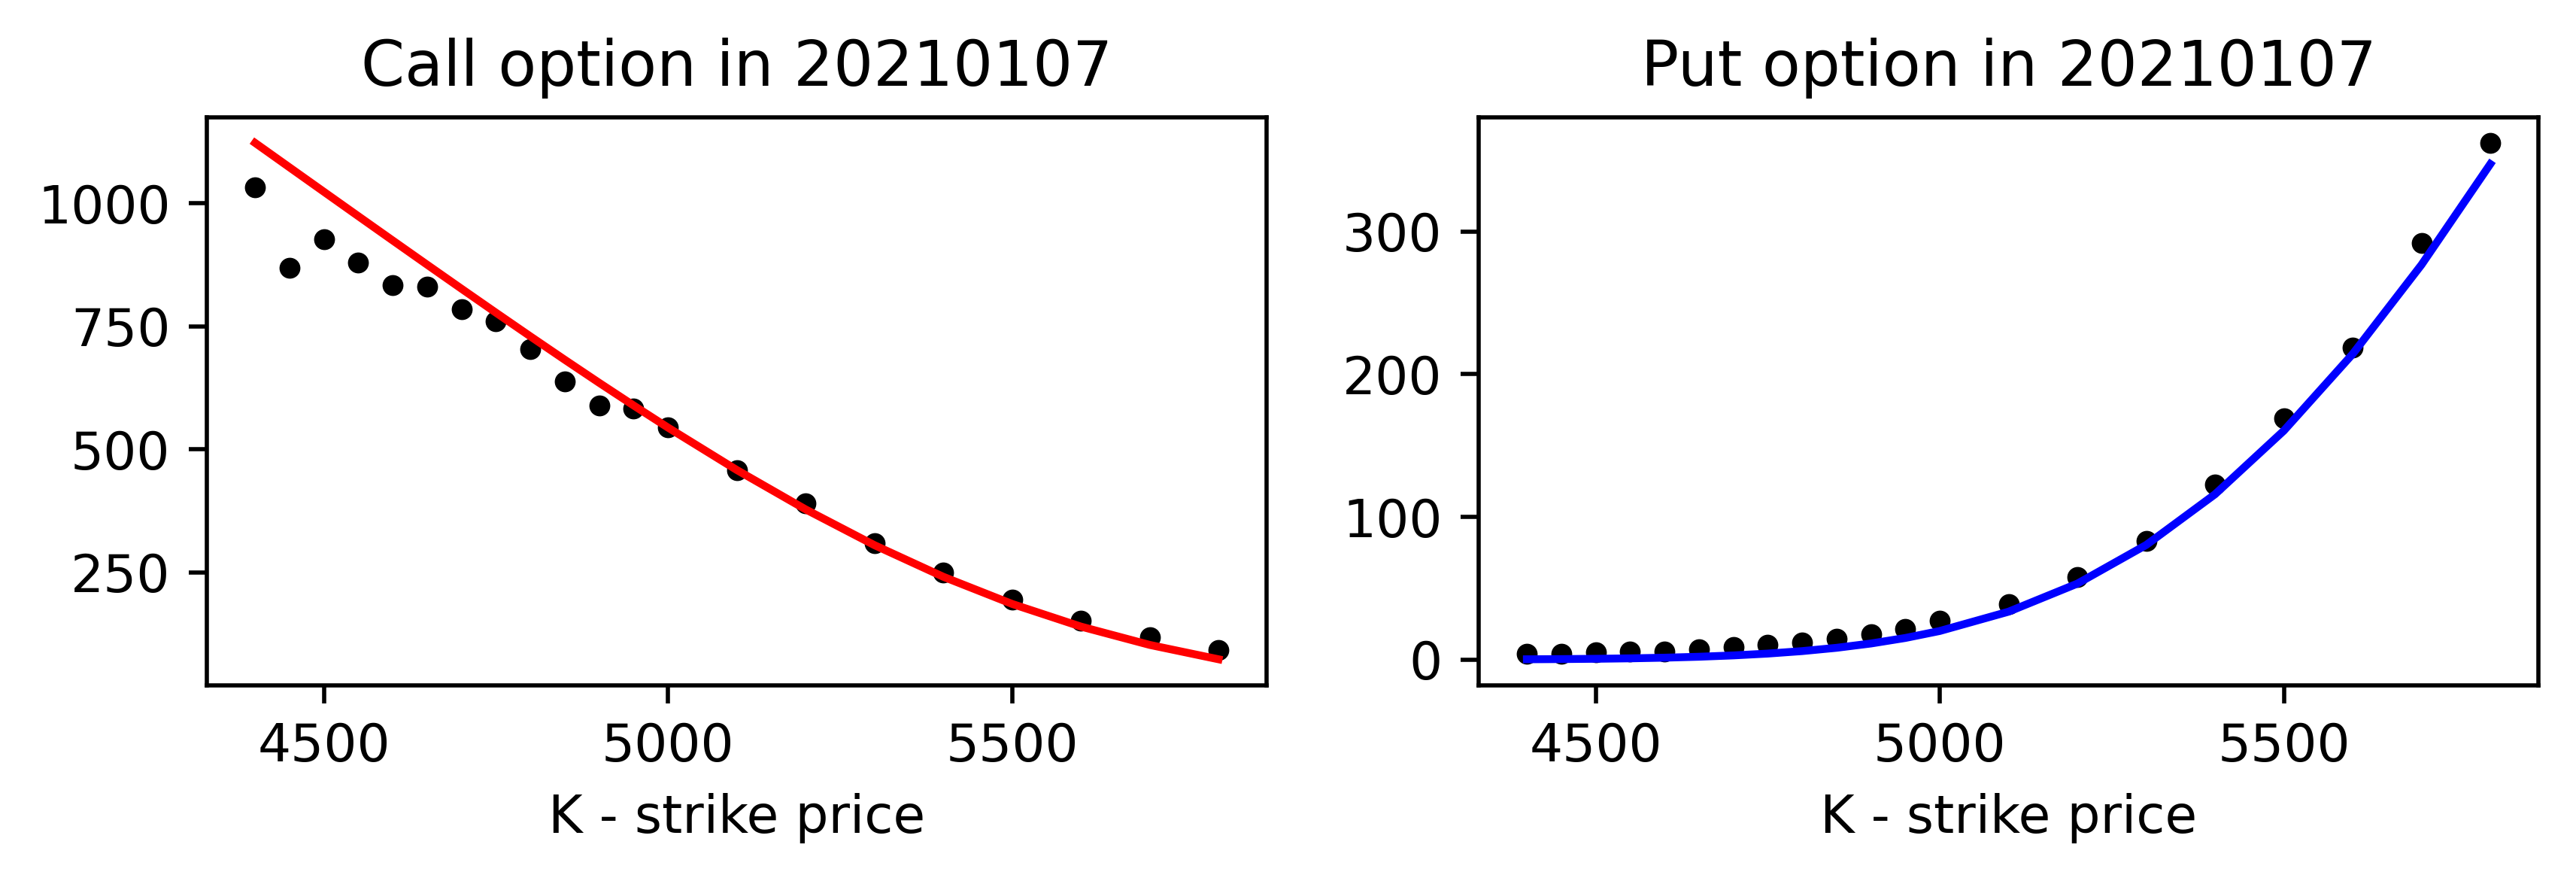

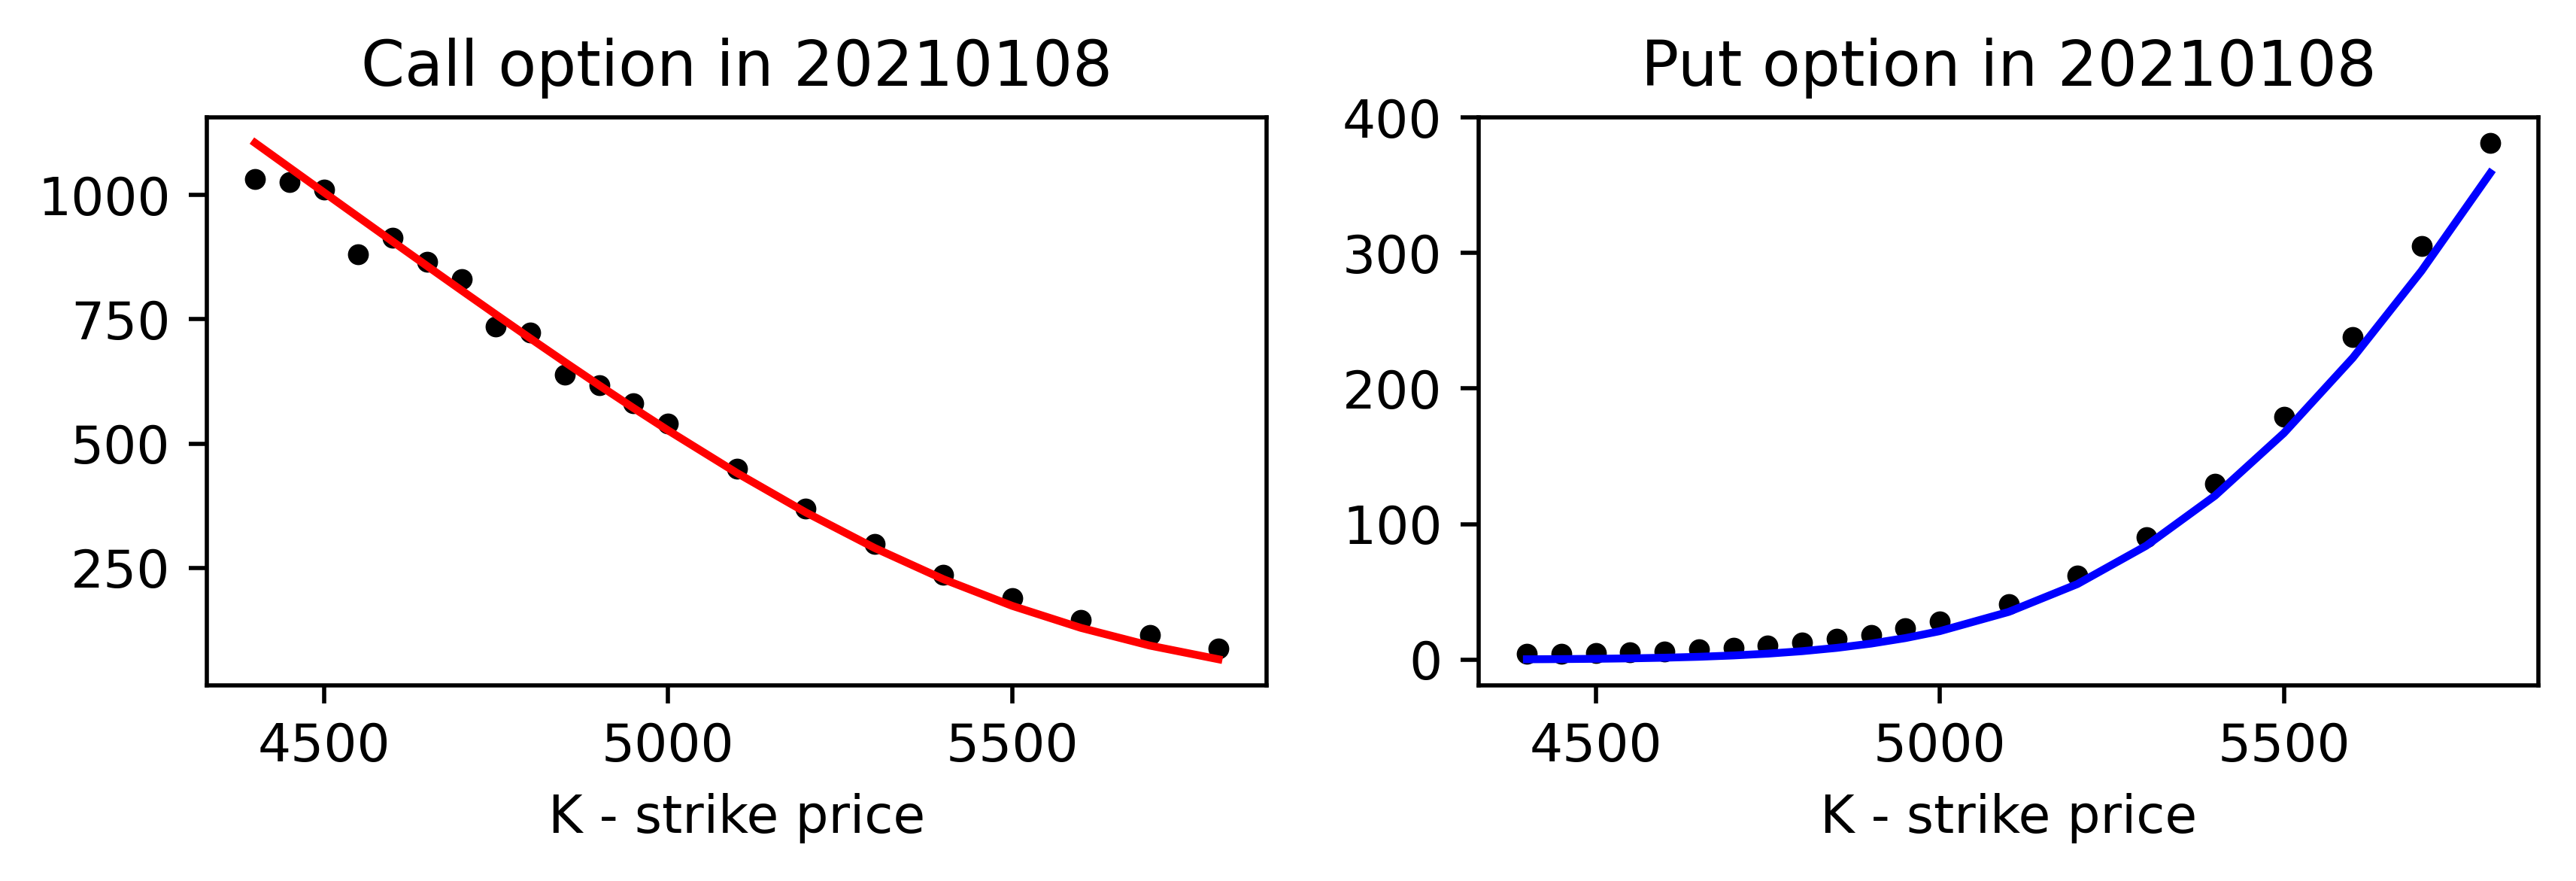

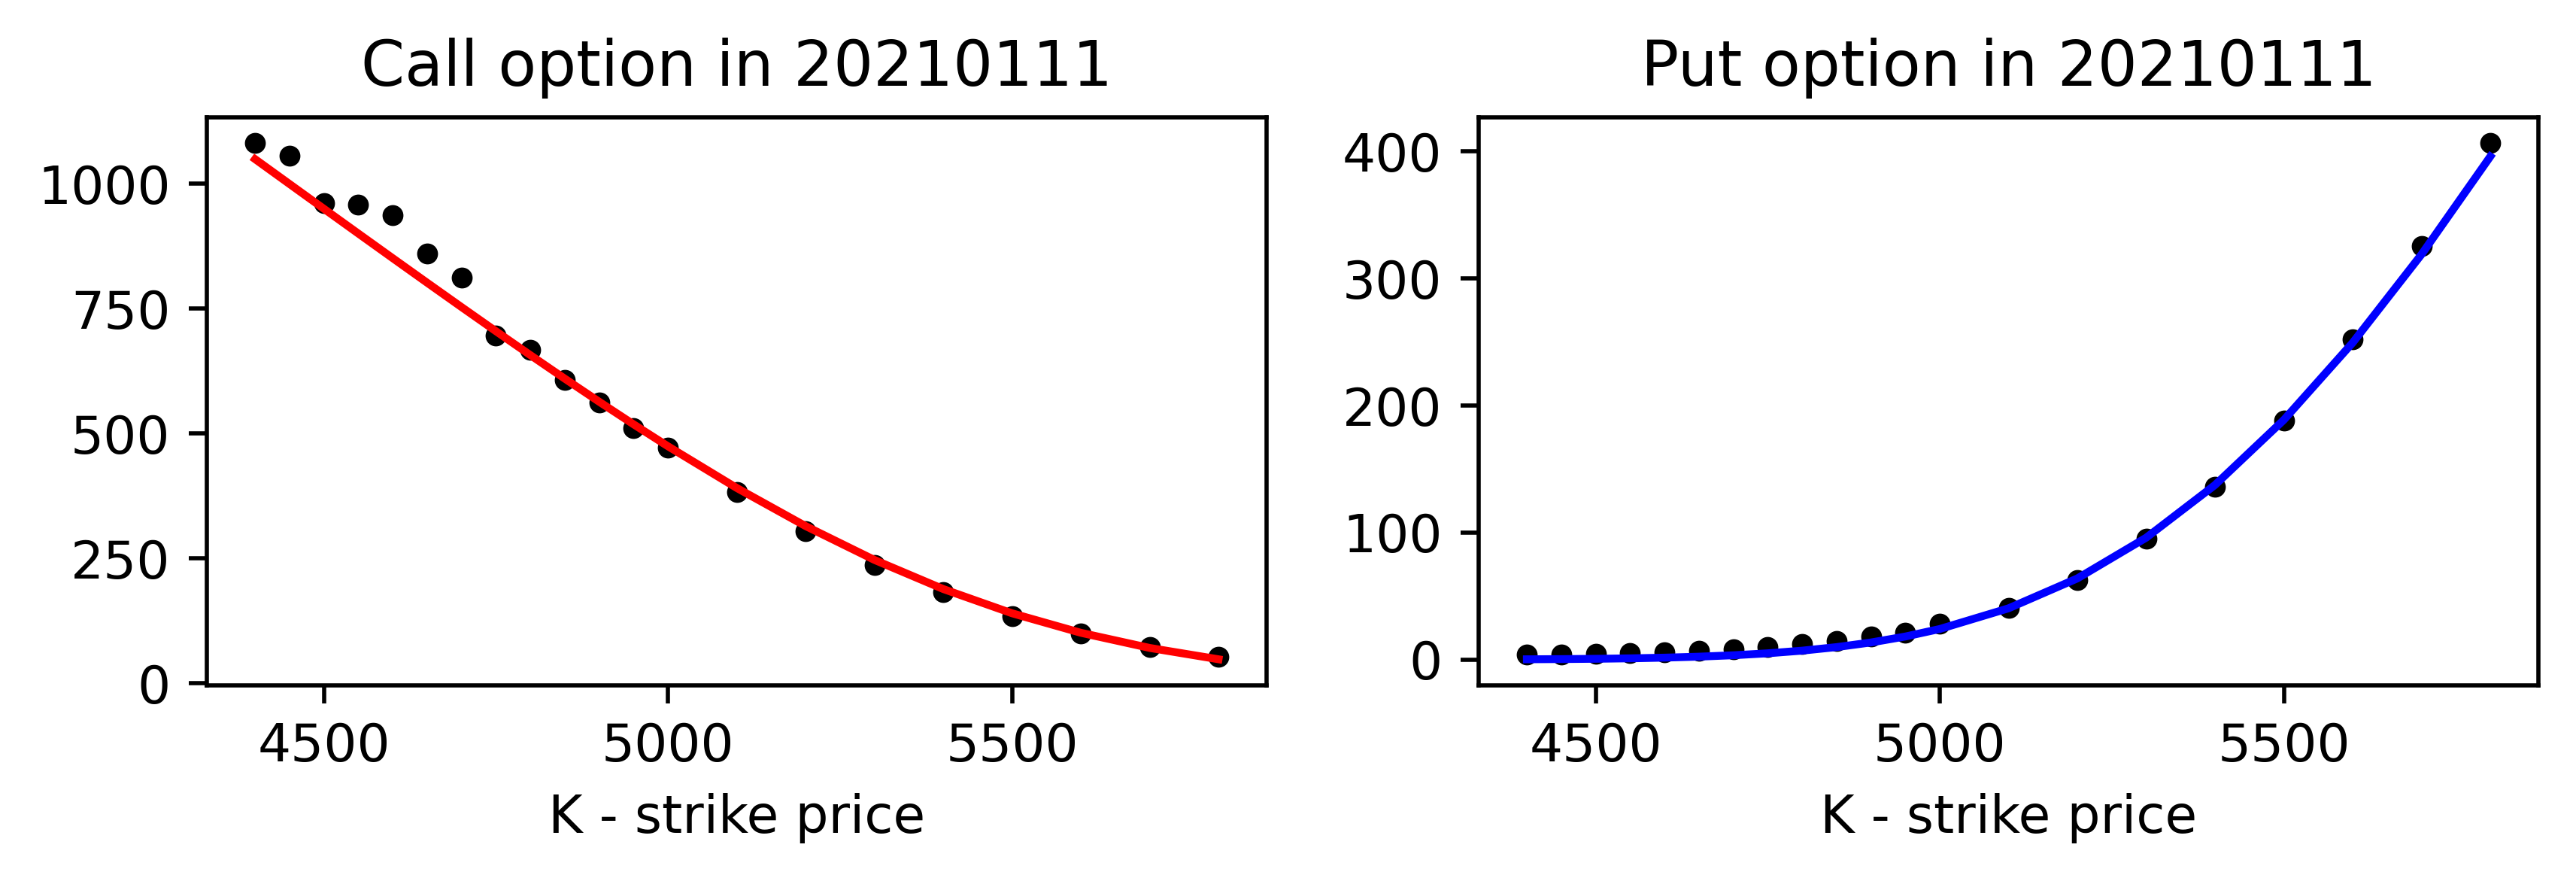

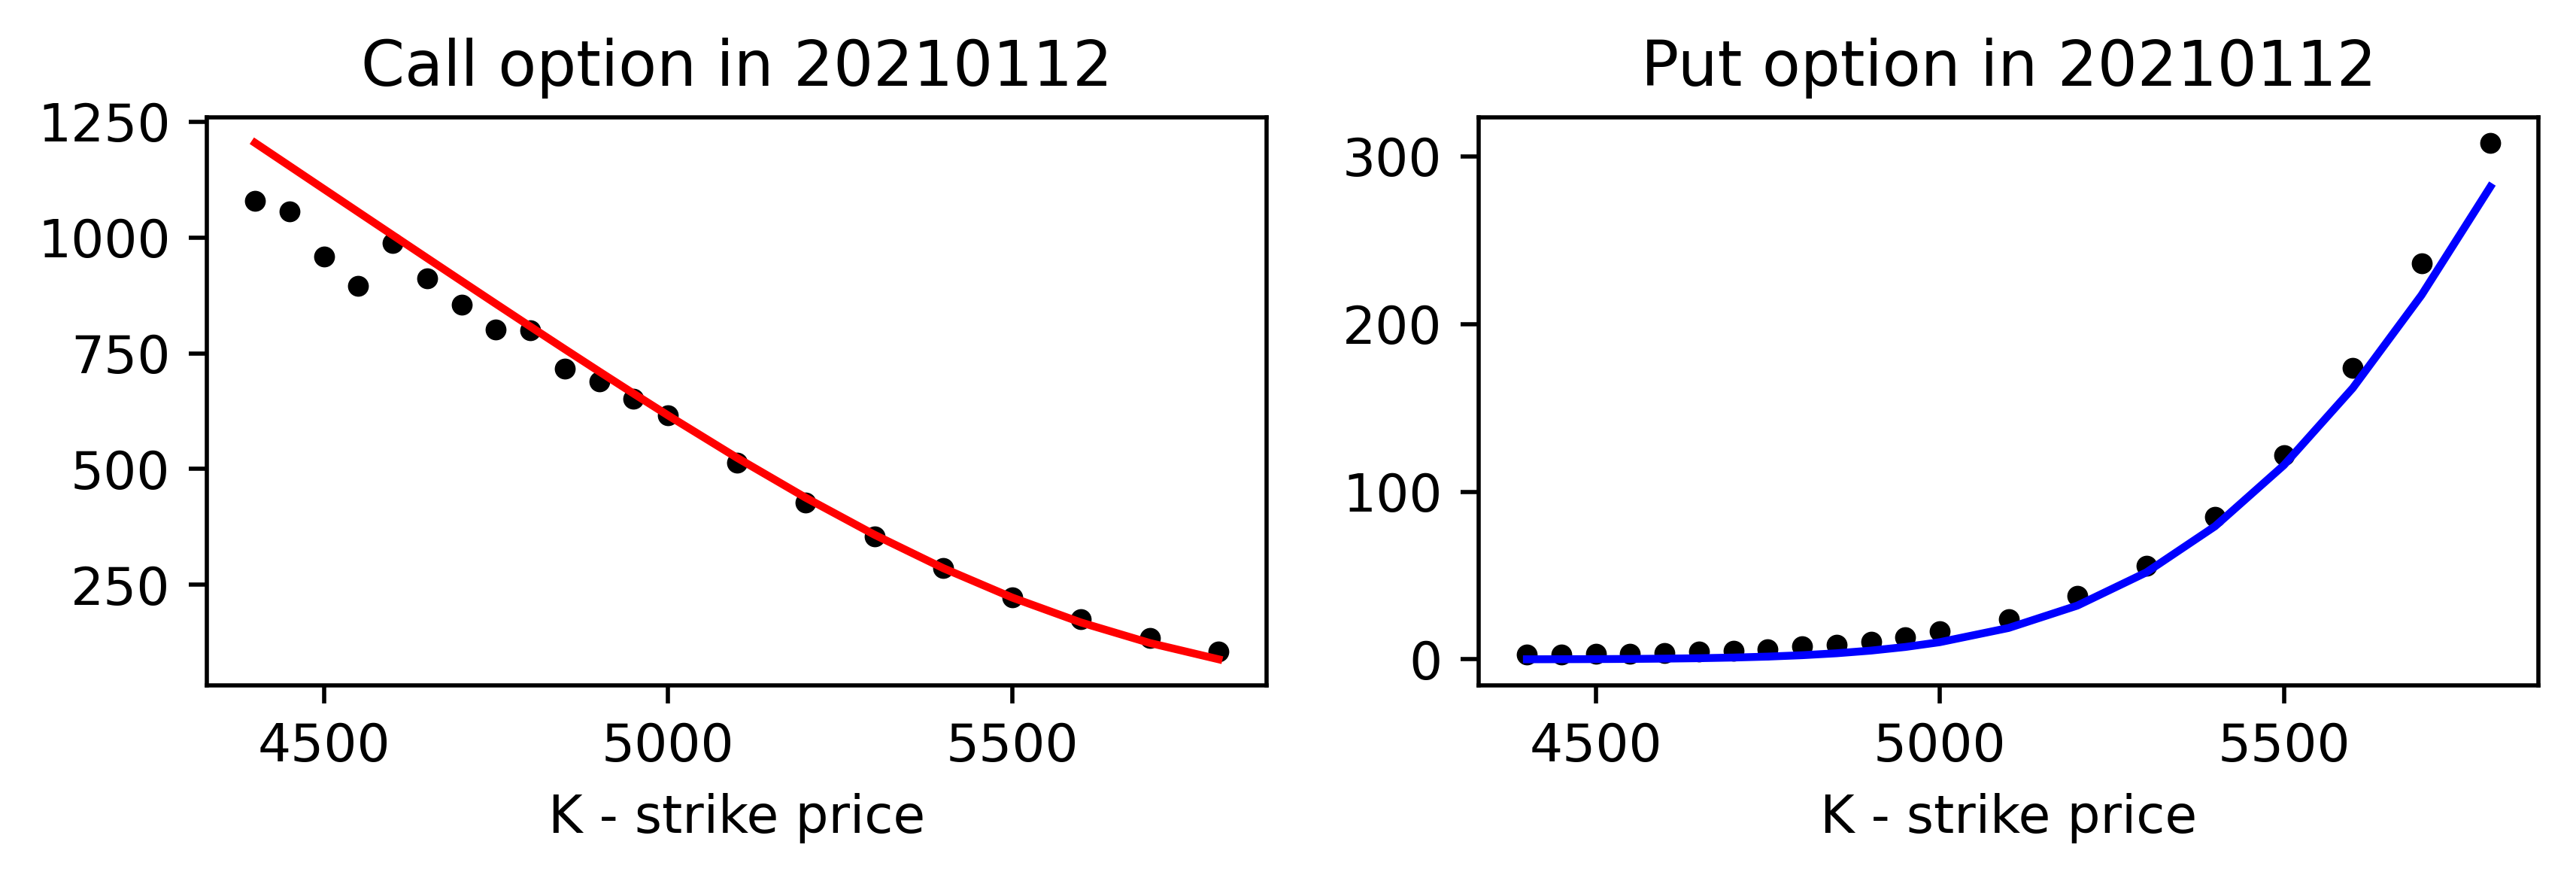

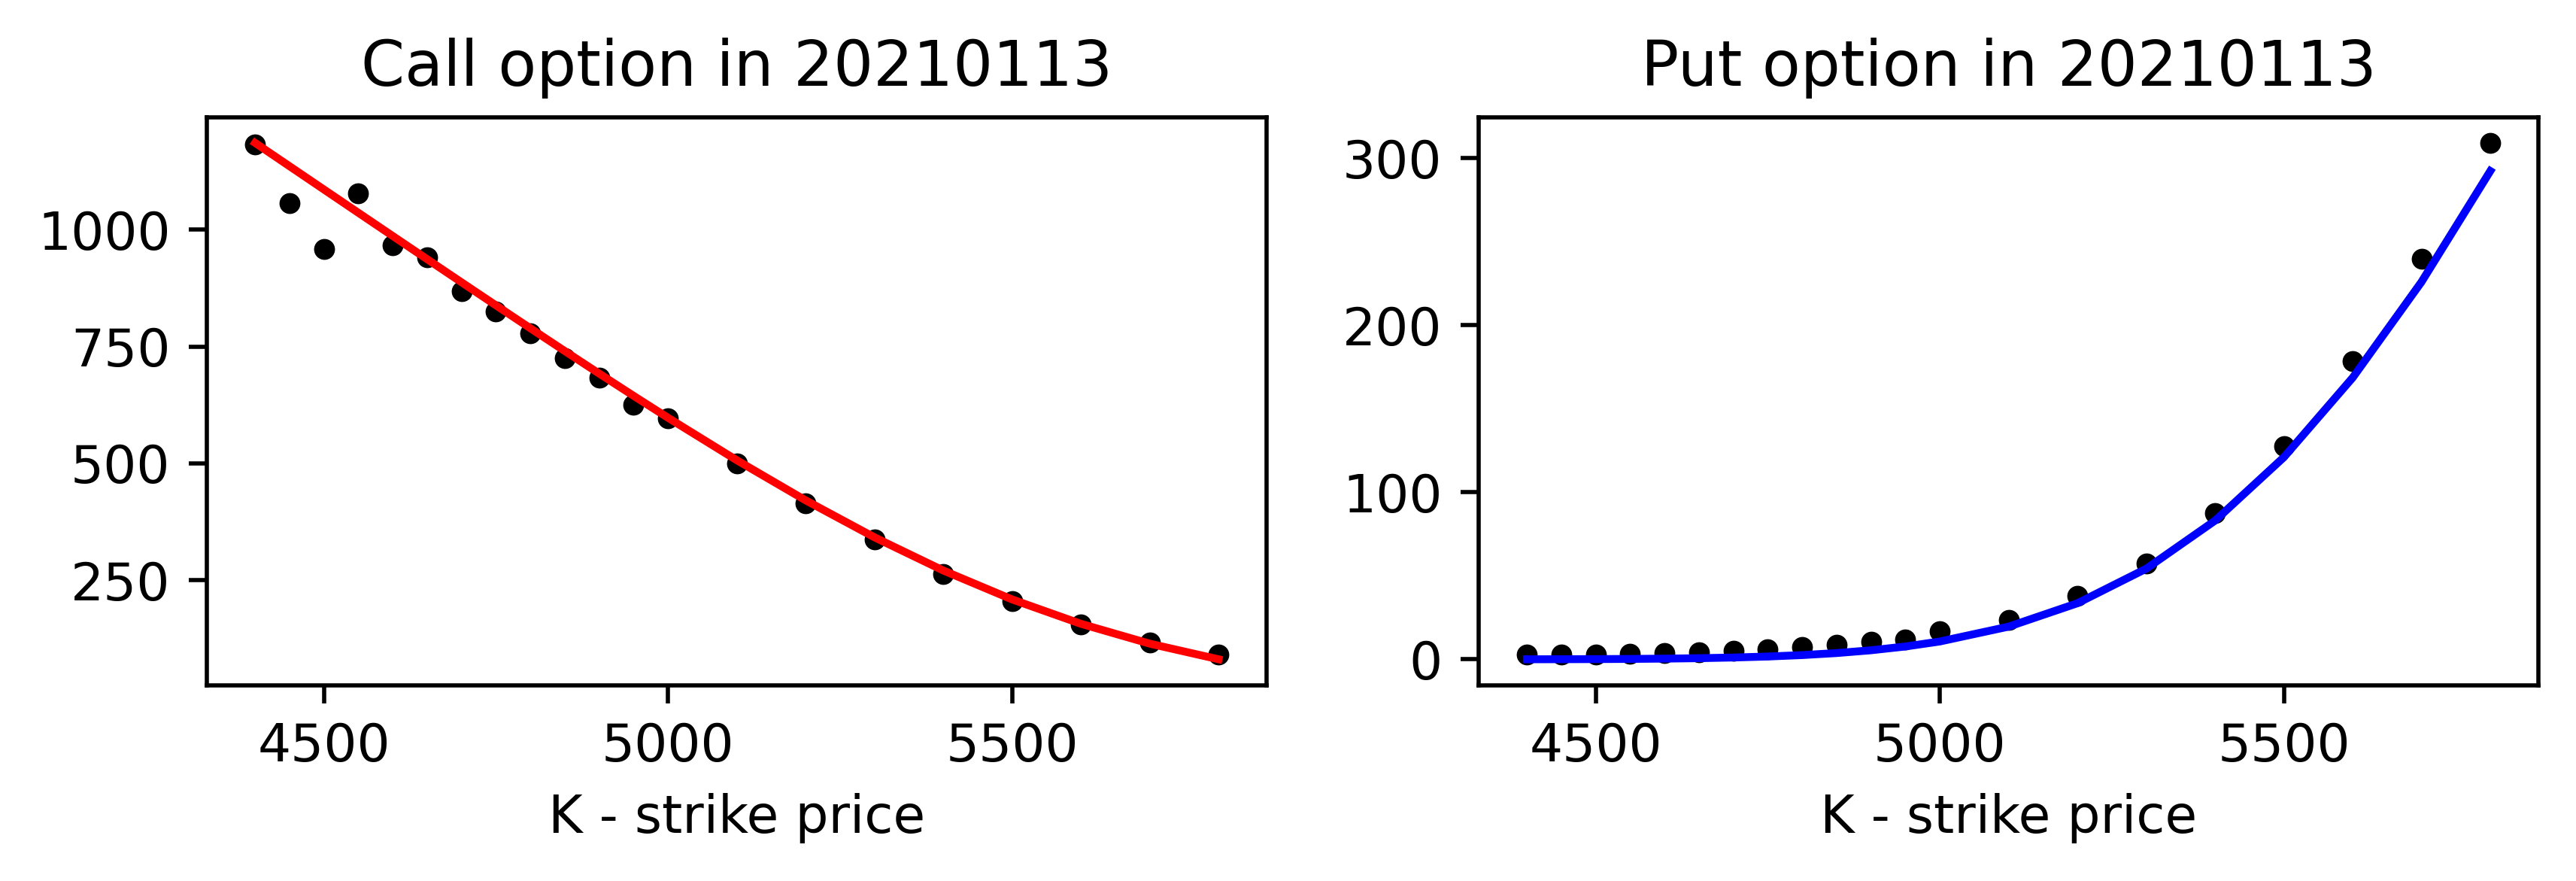

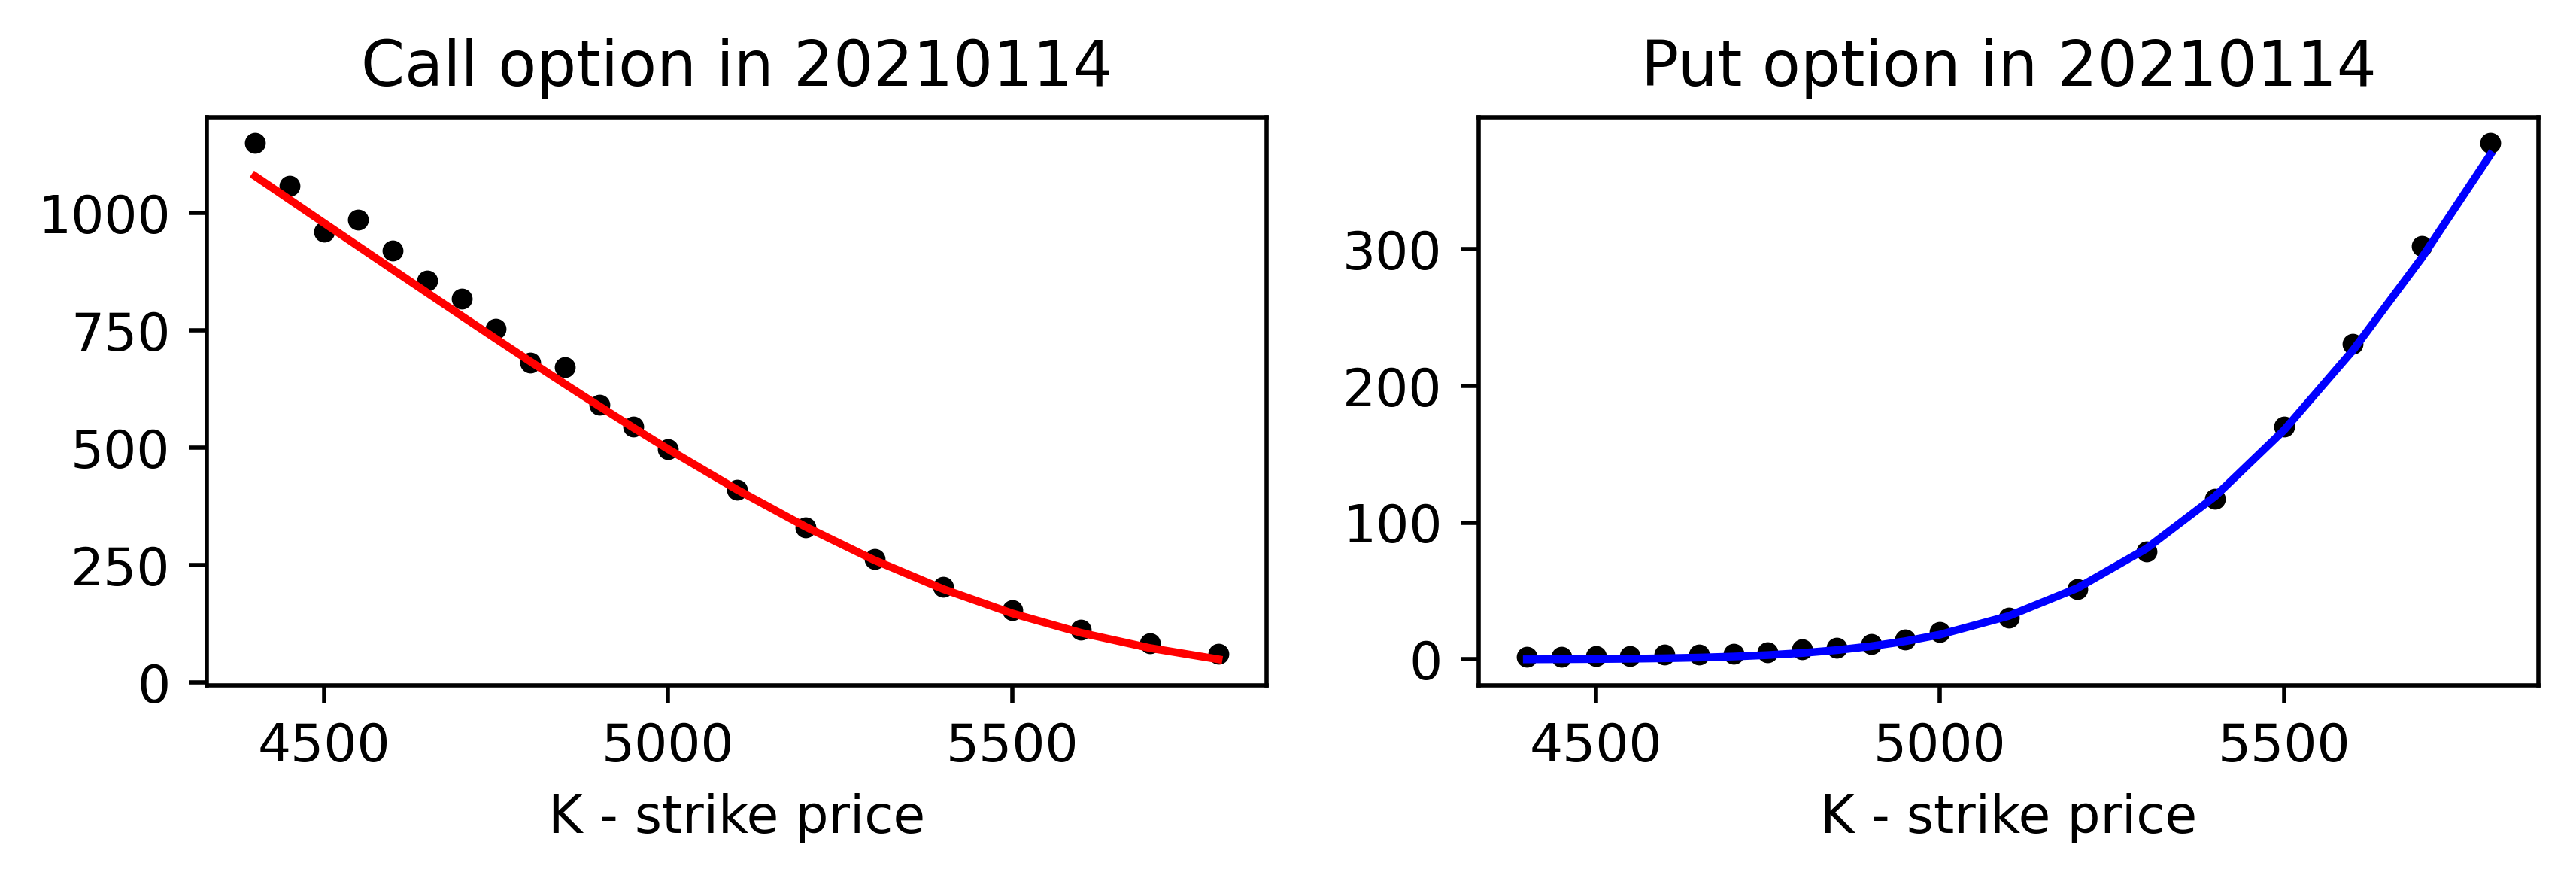

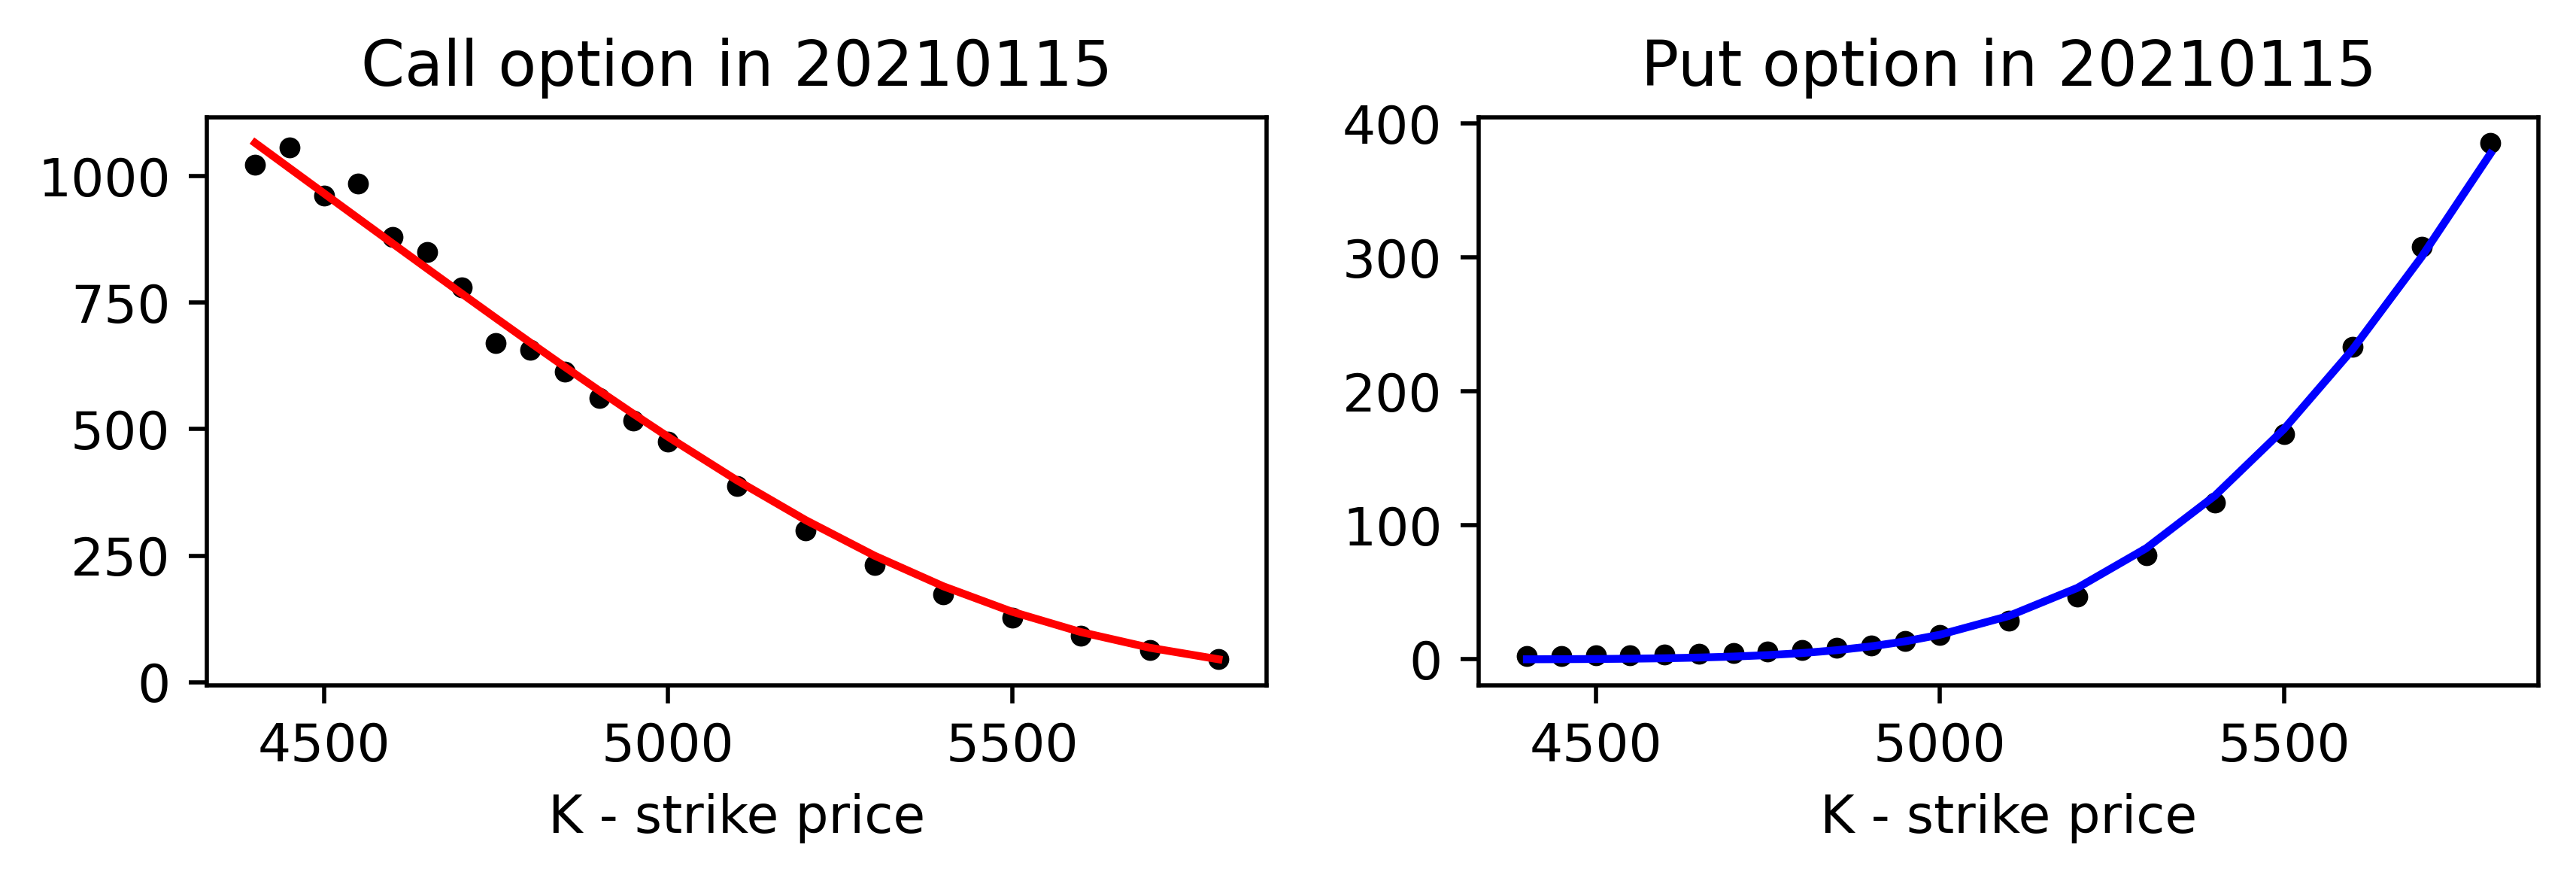

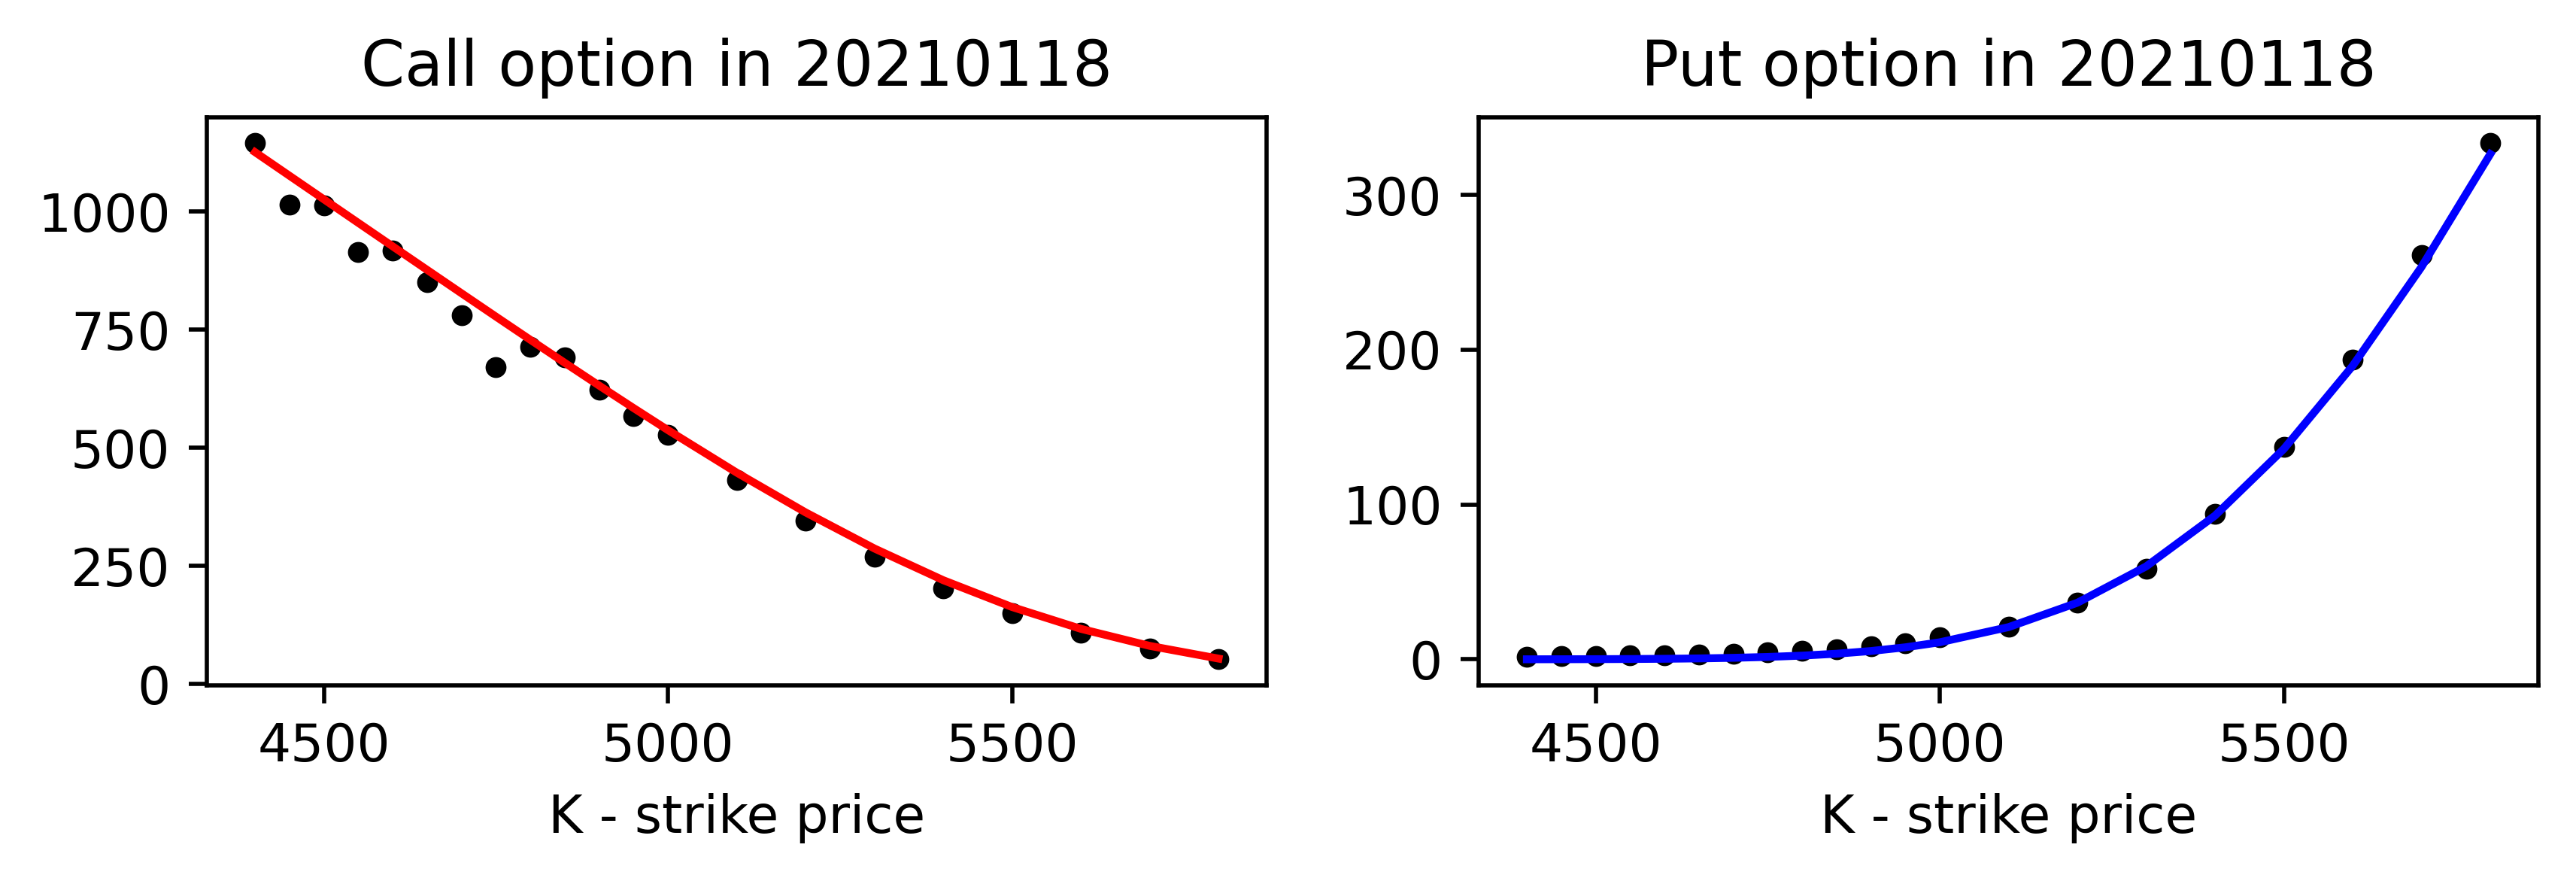

In [107]:
# 统计数据可视化
import matplotlib.pyplot as plt
import numpy as np

date_list = call.columns[1:]
x = call.strike.values

for date in date_list:
    plt.figure(dpi=500,figsize=(8,2))

    y1 = call[date].values
    y2 = call_theo[date].values
    plt.subplot(1, 2, 1)
    plt.plot(x, y2,linewidth=1.5,color='r', markerfacecolor='blue',markersize=12)
    plt.scatter(x, y1, c='k', marker='.')
    
    plt.title("Call option in " + date)
    plt.xlabel("K - strike price")

    y1 = put[date].values
    y2 = put_theo[date].values
    plt.subplot(1, 2, 2)
    plt.plot(x, y2,linewidth=1.5,color='b', markerfacecolor='blue',markersize=12)
    plt.scatter(x, y1, c='k', marker='.')

    plt.title("Put option in " + date)
    plt.xlabel("K - strike price")

    plt.show()

由图可见，理论价格和实际价格基本一致，在不同的行权价上存在细微的差异。

# 2.绘制波动率微笑

In [142]:
# 用二分法求隐含波动率
import numpy as np
def cal_imp_vol(S, K, T, r, P):
    top = 1; down = 0; counter = 0
    sigma = (top+down) / 2
    P_estimation = bsm(S, K, T, r, sigma)[1]

    while np.abs(P-P_estimation) > 0.000001:
        if P-P_estimation > 0:
            down = sigma
            sigma = (top+down) / 2
        else:
            top = sigma
            sigma = (top+down) / 2
        P_estimation = bsm(S, K, T, r, sigma)[1]

        counter += 1
        if counter > 100:
            break

    return sigma

In [143]:
# 计算隐含波动率
from dateutil.parser import parse
import copy

imp_vol = copy.deepcopy(call)
date_list = put.columns[1:]

for date in date_list:
    this_day = parse(date).date()
    days_left = (expiration-this_day).days
    index = hs['收盘价'][str(this_day)]
    for i in call.index.values:
        strike = put.strike[i]
        put_price = put[date][i]
        imp_vol[date][i] = cal_imp_vol(index, strike, days_left/365, risk_free_rate, put_price)

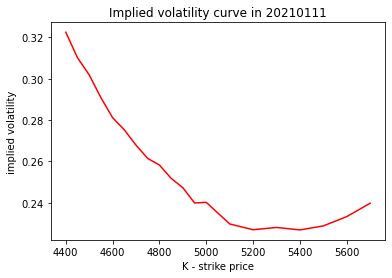

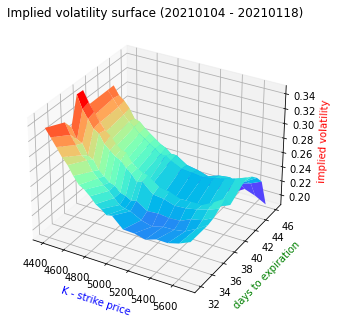

In [206]:
# 绘制波动率曲面
from dateutil.parser import parse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

data = imp_vol.drop(index = 20)

# 用x，y绘制2021.1.11当日的波动率曲线
x = data.strike.values
y = data['20210111'].values
plt.plot(x, y,linewidth=1.5,color='r', markerfacecolor='blue',markersize=12)
plt.title("Implied volatility curve in 20210111")
plt.xlabel("K - strike price")
plt.ylabel("implied volatility")
plt.show()

# 用X，Y，Z绘制一段时间内的波动率曲面
fig = plt.figure()
ax = Axes3D(fig)
X = data.strike.values
date_list = list(data.columns.values[1:])
Y = list(imp_vol.columns.values[1:])
for i in range(len(date_list)):
    Y[i] = (expiration-parse(date_list[i]).date()).days
X, Y = np.meshgrid(X, Y)
Z = []
for date in date_list:
    Z.append(list(data[date].values))
Z = np.array(Z)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')
plt.title('Implied volatility surface (20210104 - 20210118)')
ax.set_xlabel('K - strike price', color='b')
ax.set_ylabel('days to expiration', color='g')
ax.set_zlabel('implied volatility', color='r')
plt.draw()
plt.show()

由图可见，波动率曲线呈现出微笑的形状。